In [1]:
import numpy as np
import pandas as pd

from os import path
import pickle
import re

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

import itertools
import time

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN

from sklearn.metrics import silhouette_score, calinski_harabaz_score, silhouette_samples

from scipy.spatial.distance import pdist, cdist, squareform

In [2]:
pd.options.display.float_format = '{:.2f}'.format

### Import Data

For the purposes of this clustering analysis, we will focus solely on the training dataset since may utilize some of the findings and approaches conducted here in our modelling and need to avoid influencing our observations and decisions with the with the test data.

In [3]:
fd = ['..','data','interim']

# Train set
fp = path.join(*fd, 'train.p')
with open(file=fp, mode='rb') as file:
    train = pickle.load(file)

### Clustering by Department 

##### User-Department Cross-Tabulation

First we will perform a cross-tabulation of users with purchases by department:

In [4]:
dept_data={}

In [5]:
dept_data['count'] = pd.crosstab(index=train['user_id'], columns=train['department'])

Taking a quick look at the distribution of the counts:

In [6]:
dept_data['count'].unstack().describe()

count   4330389.00
mean          7.49
std          23.79
min           0.00
25%           0.00
50%           1.00
75%           5.00
max        1559.00
dtype: float64

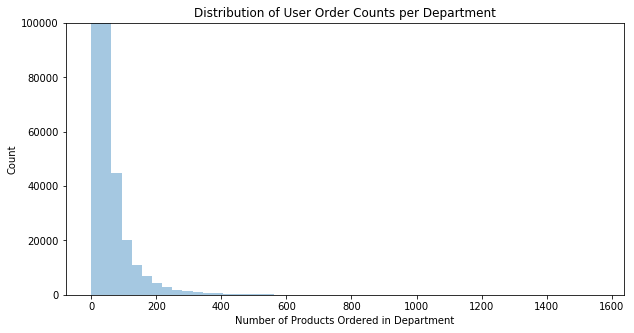

In [7]:
plt.figure(figsize=(10,5))

ax = sns.distplot(dept_data['count'].unstack(), kde=False)

ax.set_title('Distribution of User Order Counts per Department')
ax.set_xlabel('Number of Products Ordered in Department')
ax.set_ylabel('Count')

ax.set_ylim(top=100000)

plt.show()

This distribution is severely skewed due to a number of outlier counts in the 200+ range. Whilst we do want to give weight to significant spikes in order quantities in a given department, we need to consider scaling back large values to preserve meaning in our less extreme values.

Additionally, for fair comparison between users and departments, we should emphasize the proportions of user taste versus plain quantity, as users with more orders will naturally have higher counts of departments ordered from. To accomplish this we will normalize each user's values relative to their minimum/maximum values to obtain a new value on the [0,1] scale.

For the sake of flexibility in evaluation down the line, we will capture two normalized tabulations: one utilizing the original values and another using log-scaled values.

In [8]:
dept_data['count_norm'] = dept_data['count'].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)

In [9]:
dept_data['count_log_norm'] = dept_data['count'].apply(lambda x: np.log(1+x)).apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)

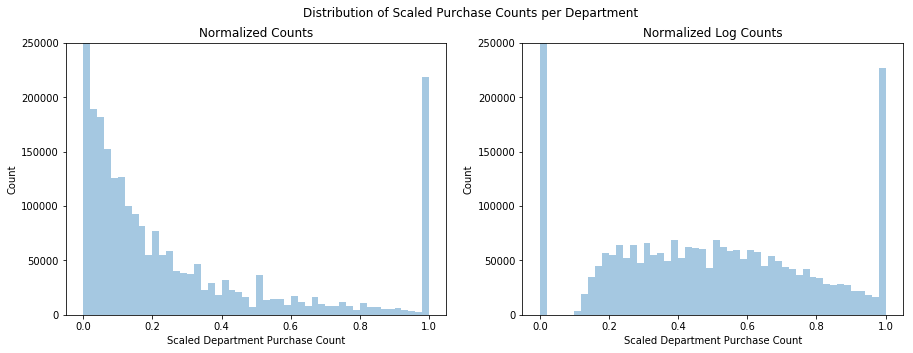

In [10]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.distplot(dept_data['count_norm'].unstack(), kde=False, ax=axs[0])
sns.distplot(dept_data['count_log_norm'].unstack(), kde=False, ax=axs[1])

for ax in axs:
    ax.set_xlabel('Scaled Department Purchase Count')
    ax.set_ylabel('Count')
    ax.set_ylim(top=250000)
    
axs[0].set_title('Normalized Counts')
axs[1].set_title('Normalized Log Counts')

fig.suptitle('Distribution of Scaled Purchase Counts per Department')

plt.show()

We can see that the log-scaled approach prior to normalization yields a much more uniform distribution in the 0.2-0.8 range, whereas the default approach is more akin with the rapid decay with increasing value seen in our original distribution.

Another possibility is to revisit how orders per department are tallied. The cross tabulation above does not discount multiple products from the same department being purchased in a given order. Thus, an alternative method would be to only tally departments once per order placed (i.e. capturing "department x was in this order"). Whether or not this is the ideal approach can only be determined through ultimate performance evaluation, so we will build these tabulations as well for future comparisons:

In [11]:
# Remove duplicate records of department per order
temp = train.drop_duplicates(subset=['order_id', 'department_id'])

dept_data['tally'] = pd.crosstab(index=temp['user_id'], columns=temp['department'])

del temp

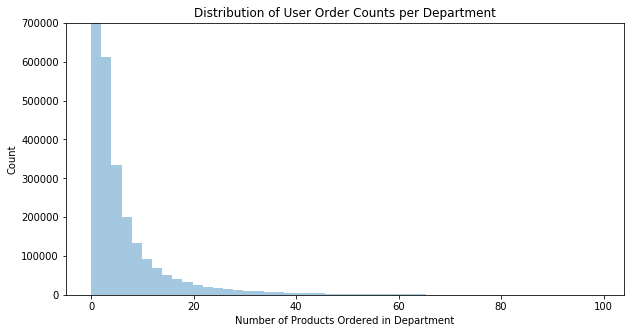

In [12]:
plt.figure(figsize=(10,5))

ax = sns.distplot(dept_data['tally'].unstack(), kde=False)

ax.set_title('Distribution of User Order Counts per Department')
ax.set_xlabel('Number of Products Ordered in Department')
ax.set_ylabel('Count')

ax.set_ylim(top=700000)

plt.show()

In [13]:
dept_data['tally_norm'] = dept_data['tally'].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)
dept_data['tally_log_norm'] = dept_data['tally'].apply(lambda x: np.log(1+x)).apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)

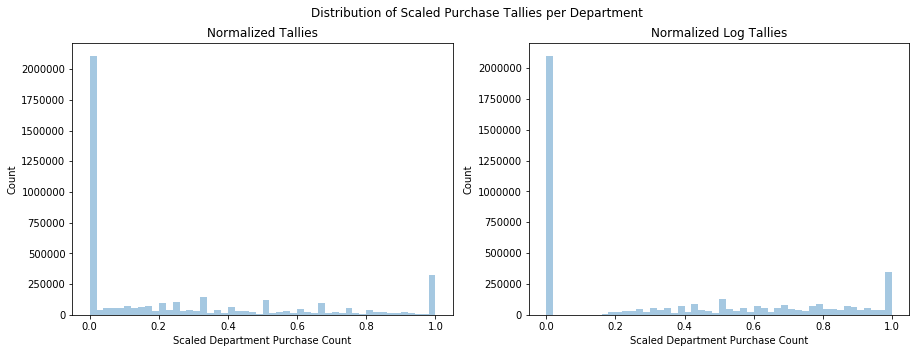

In [14]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.distplot(dept_data['tally_norm'].unstack(), kde=False, ax=axs[0])
sns.distplot(dept_data['tally_log_norm'].unstack(), kde=False, ax=axs[1])

for ax in axs:
    ax.set_xlabel('Scaled Department Purchase Count')
    ax.set_ylabel('Count')
    
axs[0].set_title('Normalized Tallies')
axs[1].set_title('Normalized Log Tallies')

fig.suptitle('Distribution of Scaled Purchase Tallies per Department')

plt.show()

Finally, in terms of capturing a true taste profile for a given user we can calculate the mean proportions of departments per order:

In [15]:
p_count = train.groupby(['user_id','order_id','department'])['product_id'].count().unstack().reset_index(level=1, drop=True)

In [16]:
p_count.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
1,nan,nan,nan,1.00,nan,nan,nan,1.00,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,4.00,2.00
1,nan,nan,nan,1.00,nan,nan,nan,1.00,nan,nan,...,nan,nan,nan,nan,nan,1.00,nan,nan,nan,2.00
1,nan,nan,nan,1.00,1.00,nan,nan,1.00,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00
1,nan,nan,nan,1.00,nan,nan,nan,1.00,nan,nan,...,1.00,nan,nan,nan,nan,nan,nan,nan,nan,2.00
1,nan,nan,nan,2.00,nan,nan,nan,2.00,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00


In [17]:
p = p_count.div(p_count.sum(axis=1).values,axis=0)

In [18]:
p_mean = p.fillna(0).groupby('user_id').mean()

In [19]:
p_mean_norm = p_mean.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)

In [20]:
p_mean_norm.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.00,0.00,0.58,0.12,0.00,0.00,0.56,0.00,0.00,...,0.10,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.17,1.00
2,0.00,0.00,0.05,0.18,0.07,0.00,0.03,1.00,0.56,0.00,...,0.00,0.08,0.02,0.00,0.00,0.25,0.02,0.00,0.88,0.95
3,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.54,0.05,0.11,...,0.02,0.00,0.00,0.00,0.00,0.11,0.00,0.00,1.00,0.24
4,1.00,0.00,0.39,0.89,0.00,0.00,0.14,0.00,0.67,0.00,...,0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.33
5,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.35,0.04,0.05,...,0.00,0.08,0.00,0.00,0.00,0.10,0.00,0.00,1.00,0.05


In [21]:
dept_data['p_mean_norm'] = p_mean_norm

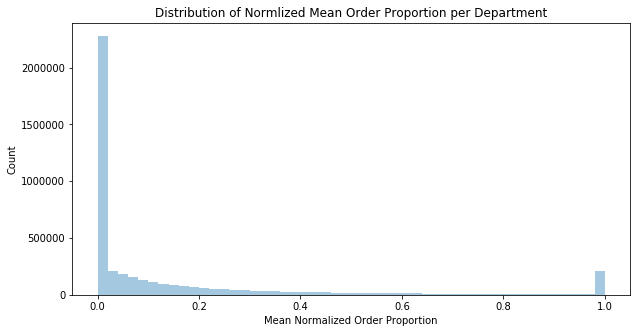

In [22]:
plt.figure(figsize=(10,5))

ax = sns.distplot(dept_data['p_mean_norm'].unstack(), kde=False)

ax.set_xlabel('Mean Normalized Order Proportion')
ax.set_ylabel('Count')

plt.title('Distribution of Normlized Mean Order Proportion per Department')

plt.show()

### Dimension Reduction

With a total of 21 departments, dimensionality is not a huge concern relative to our other categories (i.e. aisles and products). Regardless, it may prove useful for clustering to eliminate some of the noise from less important/prevalent departments in trying to cluster customers. We will use PCA to see what can be accomplished in the ways of dimensionality reduction whilst still maintaining the majority of the original information.

In [80]:
def plot_pca_var(X, p=0.9):
    
    # Create PCA object
    pca = PCA()
    pca.fit(X)
    
    # Create figure
    plt.figure(figsize=(10,5))
    
    # Get the explained variance and cumulative sum
    n = len(pca.explained_variance_ratio_)
    exp_var = pca.explained_variance_ratio_
    exp_var_cumsum = np.cumsum(exp_var)
    
    # Plot bars for explained variance of each component
    plt.bar(np.arange(1, n+1, 1), exp_var, align='center', label='Explained Variance Ratio')
    # Plot steps for cumulative explained variance
    plt.step(np.arange(1, n+1, 1), exp_var_cumsum, where='mid', label='Cumulative Explained Variance Ratio')
    
    # n_components at which minimum cumalative variance explained is satisfied
    x = next(i for i, n in enumerate(exp_var_cumsum) if n >= p) + 1
    # Markings at the specified desired percentage variance explained
    plt.hlines(p, 0, n, label='{}% Explained Variance Ratio'.format(p*100), lw=1, color='r', linestyle='dashed')
    plt.plot([x, x], [0, p], linestyle='--',color='k', markeredgewidth=3, ms=8, lw=1)
    plt.plot([x], [p], marker='x', color='k', markeredgewidth=2, ms=8, lw=.5)
    plt.annotate(x, (x+.5, p-0.05))
    
    # Generic plot labels
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlim(0, n)
    plt.title('Principal Component Analysis')
        
    # return figure
    return plt.gcf()

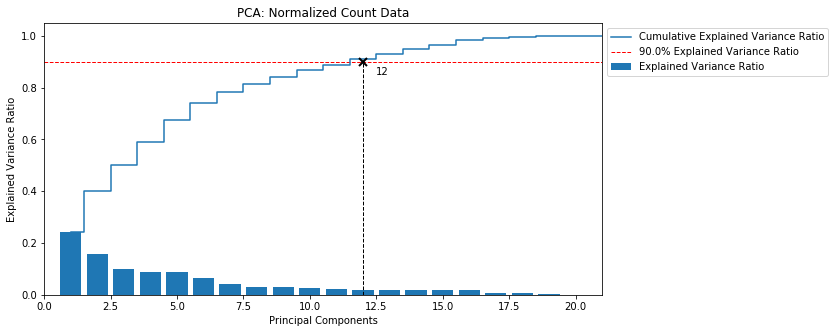

In [96]:
fig = plot_pca_var(dept_data['count_norm'].values, 0.90)

plt.title('PCA: Normalized Count Data')

plt.show()

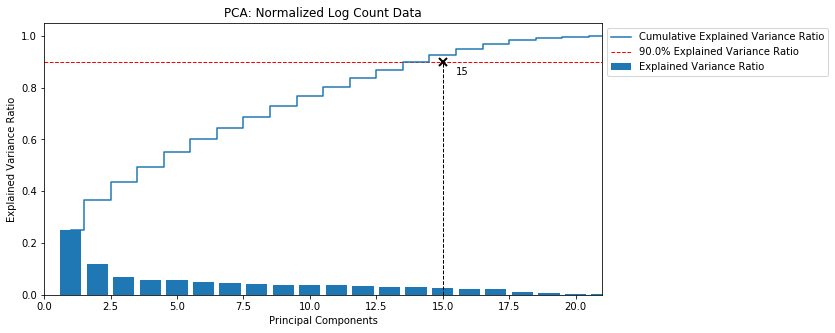

In [97]:
fig = plot_pca_var(dept_data['count_log_norm'].values, 0.90)

plt.title('PCA: Normalized Log Count Data')

plt.show()

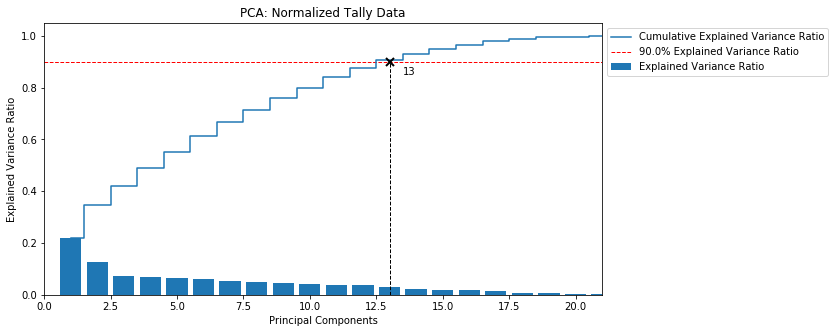

In [98]:
fig = plot_pca_var(dept_data['tally_norm'].values, 0.90)

plt.title('PCA: Normalized Tally Data')

plt.show()

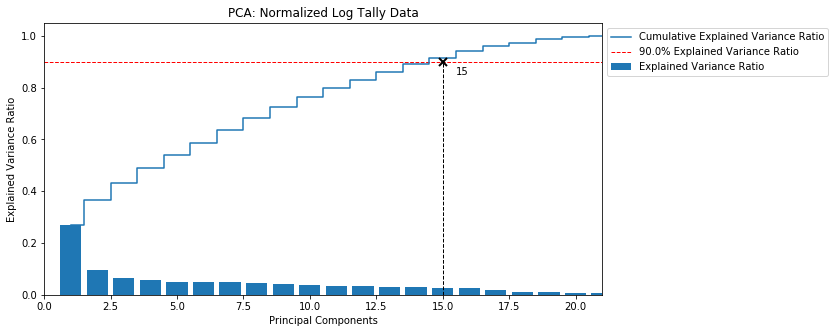

In [99]:
pca = plot_pca_var(dept_data['tally_log_norm'].values, 0.90)

plt.title('PCA: Normalized Log Tally Data')

plt.show()

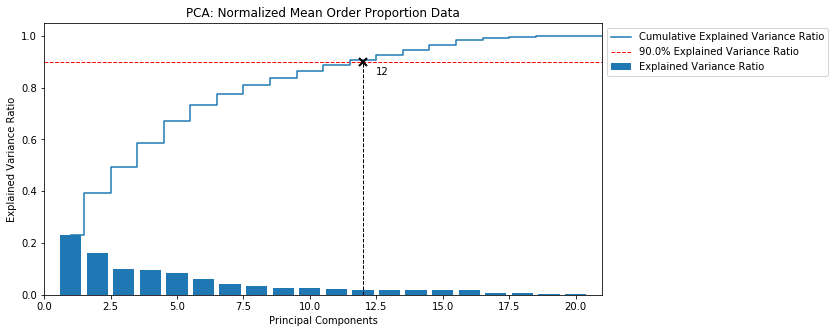

In [101]:
pca = plot_pca_var(dept_data['p_mean_norm'].values, 0.90)

plt.title('PCA: Normalized Mean Order Proportion Data')

plt.show()

With a total of 21 departments, we can see that for all scalings we are able to achieve some degree of dimensionality reduction whilst still maintaining 90% of variance explained. The norm-log scaled versions seem to be slighty less flexible which is to be expected since the log scaling is going to reduce the significance of our larger features. Similarly, the tally approach also requires a higher number of components since again we are dampening the effects of higher counts.



In [23]:
n_pca = {'count_norm': 12,
         'count_log_norm': 15,
         'tally_norm': 13,
         'tally_log_norm': 15,
         'p_mean_norm': 12}

### Clustering

The following clustering methods will be explored in tandem with our various scaling methods:

1. K Means
2. DB Scan

Hierarchal clustering has been deliberately excluded given the magnitude of data we are working with. Traditionally, hierarchal clustering is best suited for clustering smaller groups of unique labelled items, whereas we are dealing upwards of 200k customers.

##### K Means

In [22]:
def kmeans_eval(data, n=5, sil_sample_size=10000, verbose=0, batch=False, batch_size=100):
    # Create new df to store results
    df = pd.DataFrame(columns=['model', 'inertia','silhouette', 'calinski'])
    df.index.name = 'k'
    # Copy data to avoid changing original
    X = data.copy()
    
    # Number of samplings to run silhouette scoring
    n_samples=5
    # Fix silhouette sample size if larger than size of data
    if sil_sample_size > data.shape[0]:
        sil_sample_size = None
        n_samples = 1
    
    # Loop through each value of k, fit KMeans, and evaluate
    for k in range(2,n+1):
        if verbose > 0:
            print('Processing k = {} ({}/{})'.format(k, k-1,n-1), end='\r')
        # New temp dictionary for results
        km = {}
        # KMeans model
        if batch:
            km['model'] = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
        else:
            km['model'] = KMeans(n_clusters=k)
        km['model'].fit(X)
        # Scoring
        km['inertia'] = km['model'].inertia_
        km['silhouette'] = np.mean([silhouette_score(data, km['model'].labels_, sample_size=sil_sample_size) for i in range(n_samples)])
        km['calinski'] = calinski_harabaz_score(data, km['model'].labels_)
        
        # Add new evaluation to dataframe
        df.loc[k] = km
    
    if verbose > 0:
        print('Complete', ' '*50)
    
    return df

We begin by fitting KMeans to each our scaled cross-tabulations, exploring cluster counts in the range of 2 through 12 for each:

In [23]:
kmeans_results = {}
for d in ['count_norm', 'count_log_norm', 'tally_norm', 'tally_log_norm', 'p_mean_norm']:
    print(d, ':')
    pca = PCA(n_components=n_pca[d])
    X = pca.fit_transform(dept_data[d].values)
    kmeans_results[d] = kmeans_eval(data=X, n=12, verbose=1, batch=True, batch_size=1000)

count_norm :
Complete                                                   
count_log_norm :
Complete                                                   
tally_norm :
Complete                                                   
tally_log_norm :
Complete                                                   
p_mean_norm :
Complete                                                   


Inertia captures the sum of squares error for each point in a cluster and its centroid, so a lower inertia score indicates a more concentrated cluster:

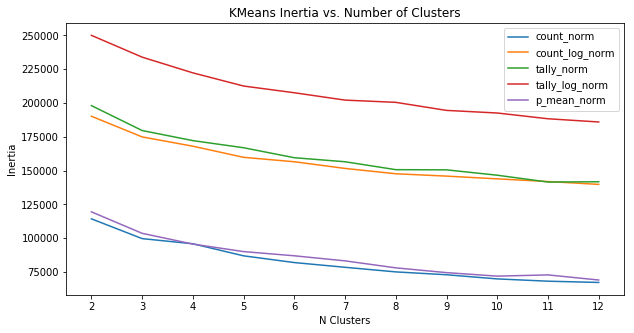

In [73]:
plt.figure(figsize=(10,5))
ax = plt.gca()

for km in kmeans_results:
    ax.plot(kmeans_results[km].index, kmeans_results[km]['inertia'], label=km)

plt.title('KMeans Inertia vs. Number of Clusters')
plt.xlabel('N Clusters')
plt.ylabel('Inertia')
plt.xticks(kmeans_results[km].index,kmeans_results[km].index)
plt.legend()

plt.show()

Looking at the intertia of our various scalings, the normalized counts and normalized mean proportions are clearly the most favorable with the least amount of error/deviation within each cluster. Identifying an optimal K value via the elbow method is difficult since it is hard to discern a strong change in the trend, but there is somewhat of an elbow at 3-5 clusters. However, decrease in inertia toward increasing clusters is still at a minimal rate, so we should not discount those options just yet.

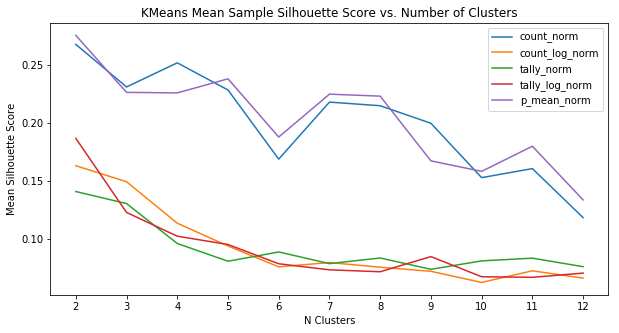

In [74]:
plt.figure(figsize=(10,5))
ax = plt.gca()

for km in kmeans_results:
    ax.plot(kmeans_results[km].index, kmeans_results[km]['silhouette'], label=km)

plt.title('KMeans Mean Sample Silhouette Score vs. Number of Clusters')
plt.xlabel('N Clusters')
plt.ylabel('Mean Silhouette Score')
plt.xticks(kmeans_results[km].index,kmeans_results[km].index)
plt.legend()

plt.show()

The normalized count and mean proportion scalings are again the clear leaders over our alternatives. Silhouette scores peak at our base value of 2 clusters and proceed to generally decrease from there. For the ultimate purpose of separating users from one another we would ideally want more variation that just binary classification/clustering of customers, so we should prioritize higher K values. Whilst there is some odd volatility around the 6 cluster mark, we see a generally consistent score in the 0.20-0.25 range between 3 and 8 clusters.

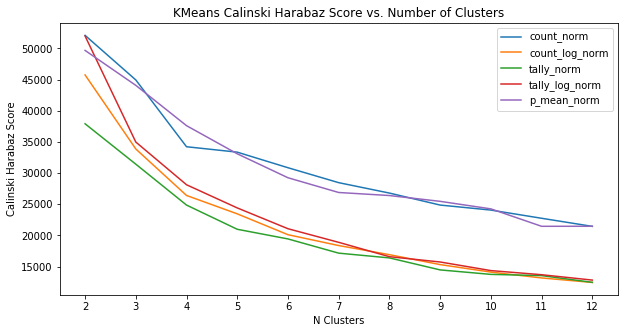

In [75]:
plt.figure(figsize=(10,5))
ax = plt.gca()

for km in kmeans_results:
    ax.plot(kmeans_results[km].index, kmeans_results[km]['calinski'], label=km)

plt.title('KMeans Calinski Harabaz Score vs. Number of Clusters')
plt.xlabel('N Clusters')
plt.ylabel('Calinski Harabaz Score')
plt.xticks(kmeans_results[km].index,kmeans_results[km].index)
plt.legend()

plt.show()

The normalized counts and mean proportions again show the strongest scores, so all 3 evaluations methods explored thus far indicate these are our best approaches for clustering. It is likely that our additional steps at scaling via tallying and log scaling have blurred the lines between purchase habits by dampening strong trends/values in purchasing habits.

As for the Calinski Harabsz scoring by clusters, we see a slight elbow at the 4-7 cluster range for our two best performing features. This further supports our focus on the 3-8 cluster range identified in our previous observations.

Taking a look at the distribution of records across each cluster in the 3-8 range for our normalized count data:

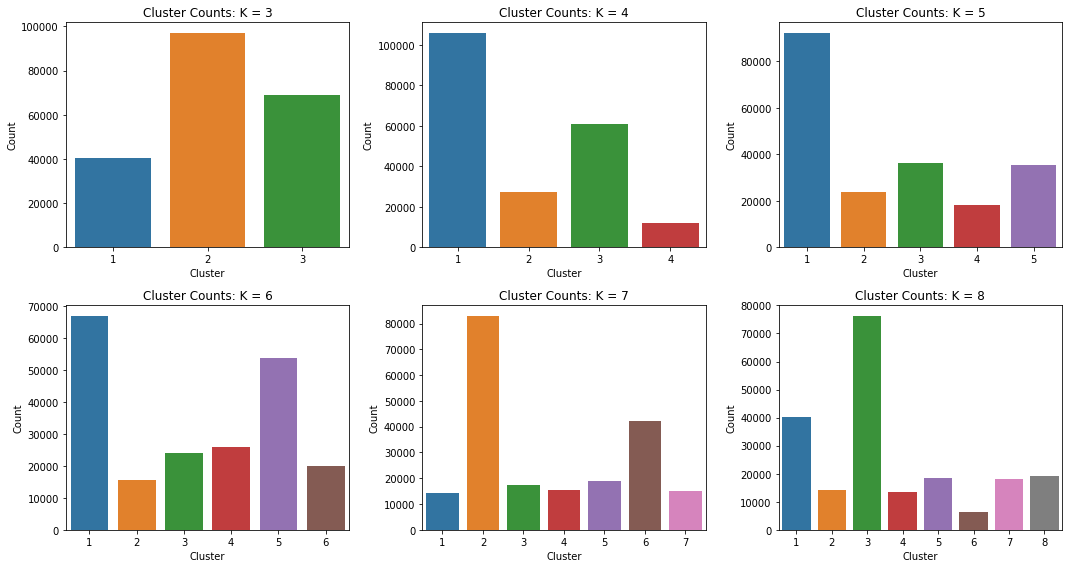

In [76]:
fig, axs = plt.subplots(2,3,figsize=(15,8))

for K, ax in zip(range(3,9),axs.flatten()):
    sns.countplot(kmeans_results['count_norm'].loc[K]['model'].labels_, ax=ax)
    ax.set_title('Cluster Counts: K = {}'.format(K))
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    ax.set_xticklabels(range(1,K+1))

plt.tight_layout()
plt.show()

For our normalized counts, 6 clusters seems to give the more uniform distirbution of items across clusters. It is worth noting that silhouette scores for 6 clusters decreased greatly for the normalized counts, which can likely be attributed to the 5 cluster fit having a single significantly larger cluster. Consequently, it may be worth valuing the 6 cluster fit more since our intention in this clustering is to create segments for customers, and if a large portion of customers generally fall under on cluster we lose potential in providing customized recommendations in said group. 

As for the normalized mean proportions:

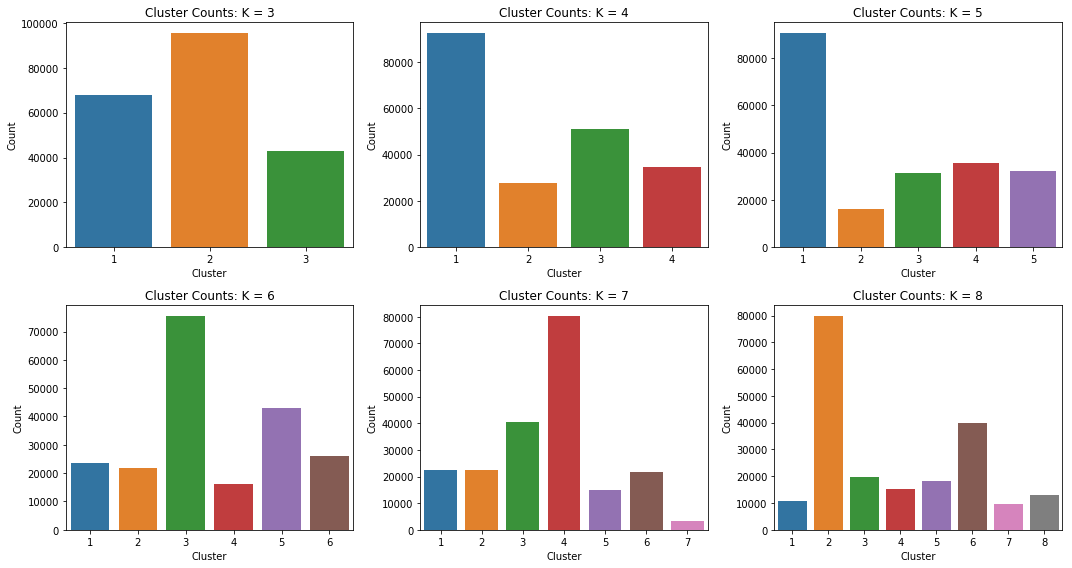

In [28]:
fig, axs = plt.subplots(2,3,figsize=(15,8))

for K, ax in zip(range(3,9),axs.flatten()):
    sns.countplot(kmeans_results['p_mean_norm'].loc[K]['model'].labels_, ax=ax)
    ax.set_title('Cluster Counts: K = {}'.format(K))
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    ax.set_xticklabels(range(1,K+1))

plt.tight_layout()
plt.show()

We can again see that the dip silhouette scores at 6 clusters are likely a result of a the single large cluster being reduced. Following the same arguments above, 6 clusters is likely a more desireable approach even if it comes at the cost of clusters being as precise since it results in the most signficant drop in user assigned to our major cluster, providing us with more diversity in our classification/segmentation.

Taking a look at various 2D slices of our various components for the normalized counts:

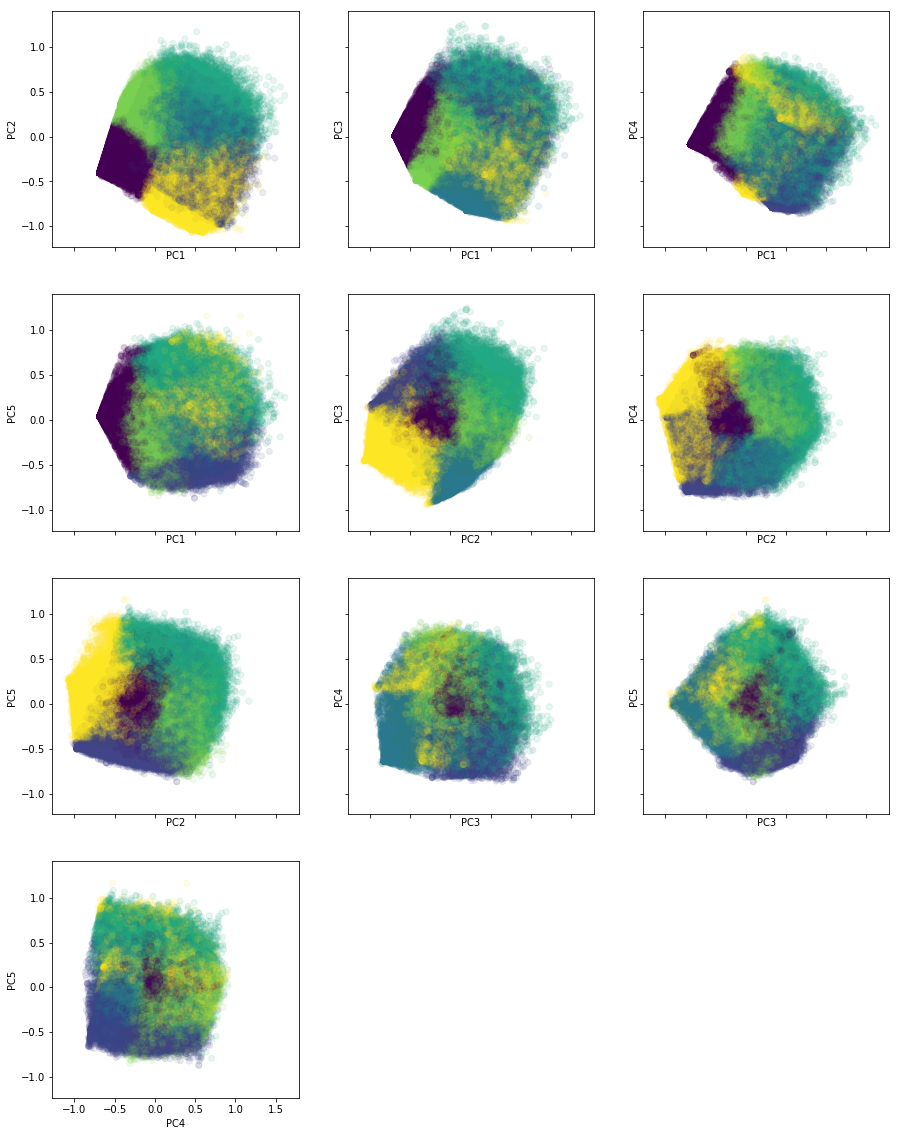

In [78]:
# 6 clusters
K=6
# Explore first 5 principle components
n_components = 5
combo_list = list(itertools.combinations(np.arange(n_components),2))

# Set up plots
n_cols = 3
n_rows = len(combo_list)//n_cols + int(len(combo_list)%n_cols > 0)
fig, axs = plt.subplots(n_rows,n_cols,figsize=(5*n_cols,5*n_rows),sharex=True,sharey=True)

# Get PCA values
X = PCA(n_components=n_pca['count_norm']).fit_transform(dept_data['count_norm'].values)

# Plot each view comparing 2 components
for ax, (pc1, pc2) in zip(axs.flatten(), combo_list):
    ax.scatter(x=X.T[pc1], y=X.T[pc2], c=kmeans_results['count_norm'].loc[K]['model'].labels_, alpha=0.1)
    ax.set_xlabel('PC{}'.format(pc1+1))
    ax.set_ylabel('PC{}'.format(pc2+1))

# Hide redundant subplots
for ax in axs.flatten()[-(n_cols - len(combo_list)%n_cols):]:
    ax.axis('off')

It is evident that across our first 5 principle components that our data is fairly cluttered and the clusters identified do not show any distinct regions of separation from one another. This aligns with our observed silhouette scores in the 0.25 range which indicated that the 'barriers' between clusters are blurred or ill-defined. This suggests the likelihood that clustering via K-Means is simply dividing our space according to the initialized points, versus actually capturing true clusters and patterns in our data. This may still prove useful for the purpose of segmenting customers by approximate regions of our 12 dimensional (reduced) department space, but one should be probably exercise caution in placing too much meaning into the significance of these clusters.

Taking a look at a 3D view with our first 3 components may yield a better view:

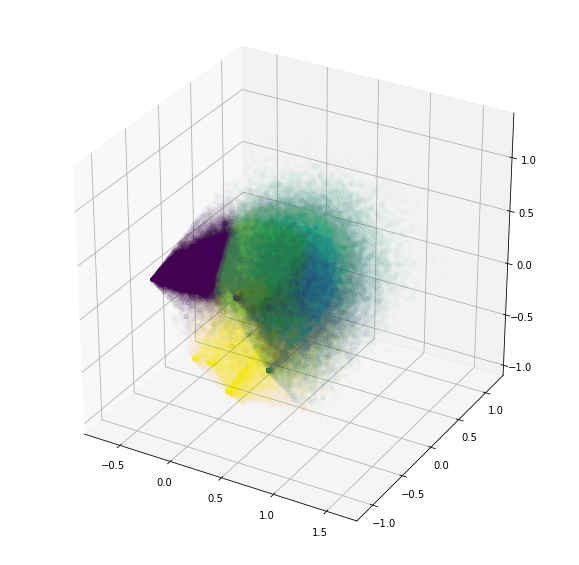

In [79]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(10,10))

ax = fig.gca(projection='3d')
ax.scatter(*X_pca_3d.T, c=kmeans_results['count_norm']['model'].loc[6].labels_, alpha=0.01)

plt.show()

In the view above we see some more reassuring results in terms of cluster separation and capturing certain regions of our dimensional space, but towards the central region we still see the aforementioned issues with clusters being very mixed.

If we take the mean scores per department by cluster, we can get an idea of the 'taste profile' for a given cluster:

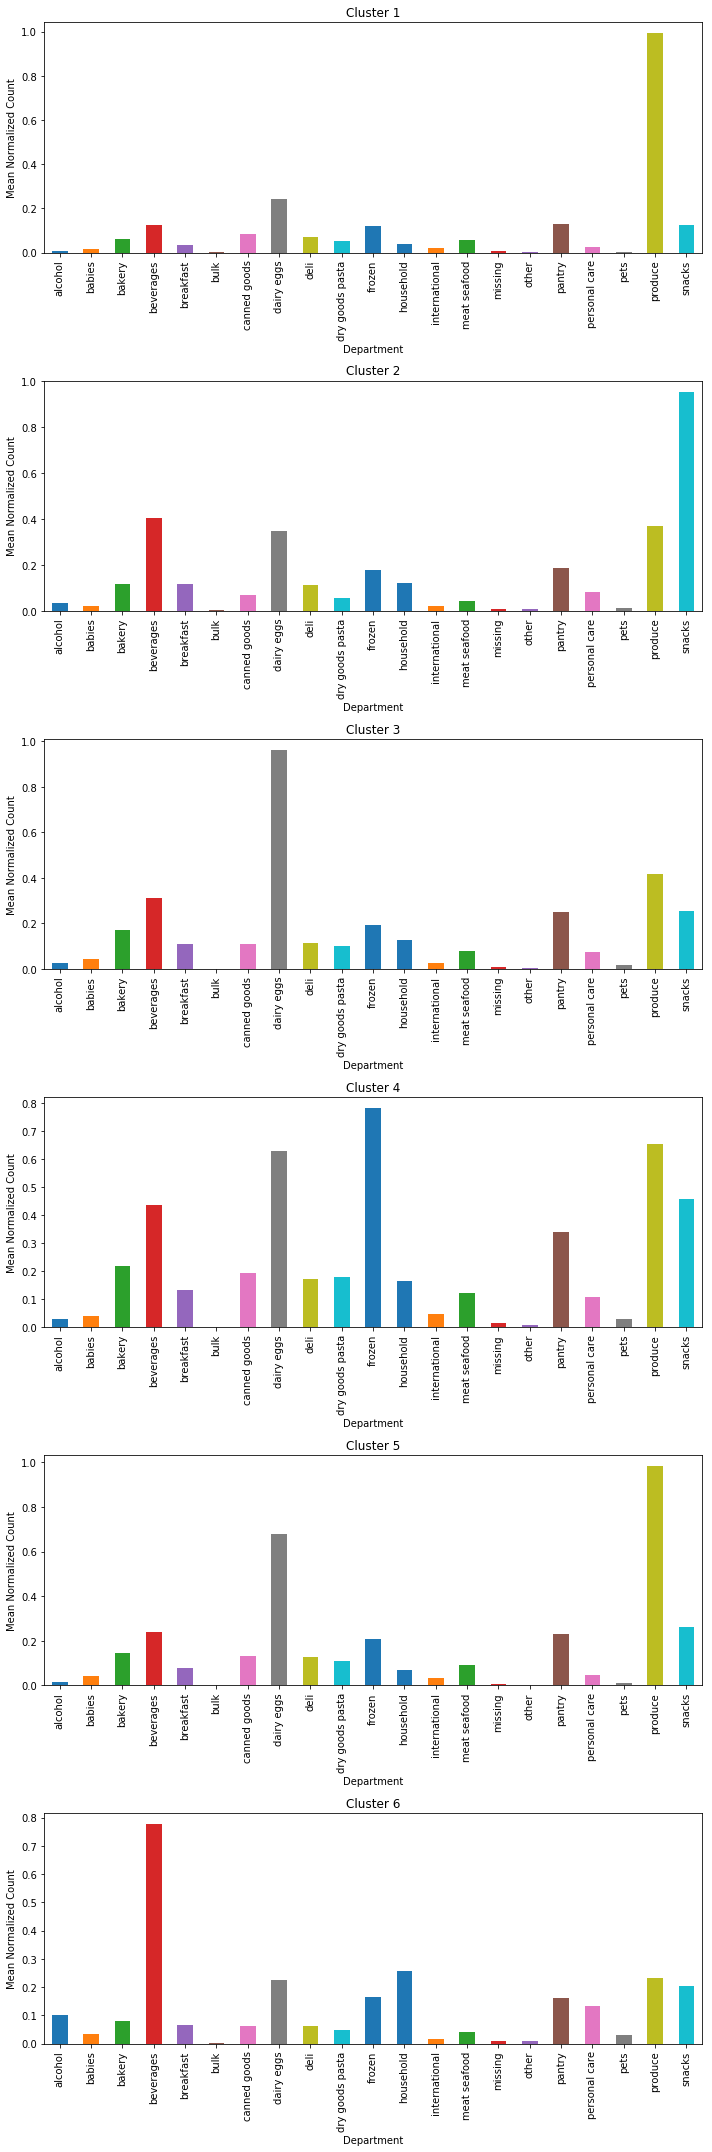

In [80]:
fig, axs = plt.subplots(6,1,figsize=(10,30))

K=6
clusters = kmeans_results['count_norm']['model'][K].labels_

for i, ax in enumerate(axs.flatten()):
    dept_data['count_norm'].groupby(clusters).mean().loc[i].plot.bar(ax=ax)
    ax.set_title('Cluster {}'.format(i+1))
    ax.set_xlabel('Department')
    ax.set_ylabel('Mean Normalized Count')

plt.tight_layout()
plt.show()

Even if the silhouette scores and such for our clustering was less than ideal, we can still see some interesting distinctions in taste profiles between clusters. Clusters and 1 and 5, for example, both have a clear emphasis on produce over all goods, with the key difference being cluster 5 also shows higher interest in dairy/eggs.

Determining the usefullness of these clusters (both via normalized count and mean proportion) will ultimately come down to comparing recommendation performance with and without these customer segments.

##### DBSCAN

Unfortunately DBSCAN is unable to process the entirety of our dataset due to memory constraints. Consequently, we will take a sample of our data to work with instead. It should be noted that fitting DBSCAN on said subsample will lead to different optimal parameters of epsilos/min. points since our data will be more sparse, so any subsequent categorization of items will need to utilize of custom process of assigning points to the nearest established cluster (or noise).

Having esablished the normalized count and mean proportion as the most useful approach for KMeans, we will proceed with using this set again for DBSCAN for consistency. It may be that one of our alternative scalings/calculations align better with DBSCAN, but given the number of parameters to explore and the time it takes to process these fits, exploring each of these is not feasible.

In [19]:
X_sample = dept_data['count_norm'].sample(n=20000)
X_pca = PCA(n_components=13).fit_transform(X_sample)

In [20]:
pairDistList = pdist(X_pca)

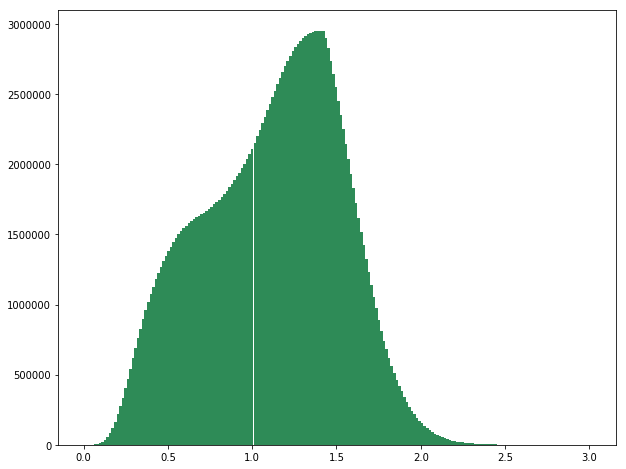

In [21]:
figPairwiseDistances = plt.figure(figsize=(10,8))

plt.hist(pairDistList, bins=200, color='seagreen')

plt.show()

In [30]:
X_sample = dept_data['p_mean_norm'].sample(n=20000)
X_pca = PCA(n_components=n_pca['p_mean_norm']).fit_transform(X_sample)

AttributeError: 'tuple' object has no attribute 'set_title'

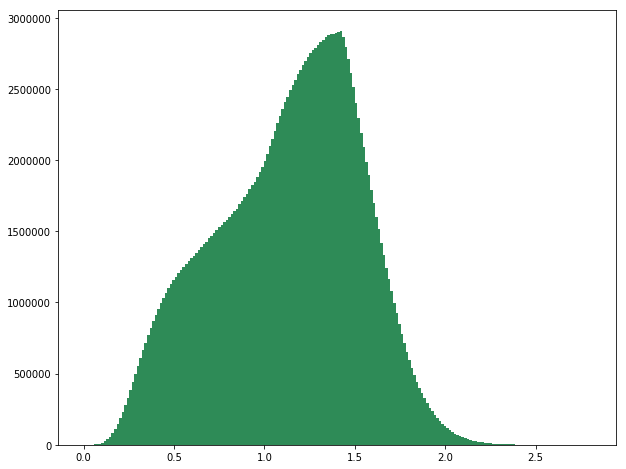

In [34]:
pairDistList = pdist(X_pca)

figPairwiseDistances = plt.figure(figsize=(10,8))

ax = plt.hist(pairDistList, bins=200, color='seagreen')

ax.set_title('Distribution of Pairwise Distances (Euclidean)')
ax.set_ylabel('Count')
ax.set_xlabel('Pairwise Distance')

plt.show()

There seems to be minimal difference in the distribution of distances for both of our measures. Since the mean proportion feature is technically a truer measure of customer taste profile, we will proceed with it for further investigation.

As for determining possible epsilon values from the graphs above, unfortunately there is no initial peak and subsequent trough to evaluate this from. One could potentially choose the inflection point as an alternative, but already this is showing some possible issues with the distribution of our data in our dimensional space.

Perhaps an alternative distance measure will provide better results:

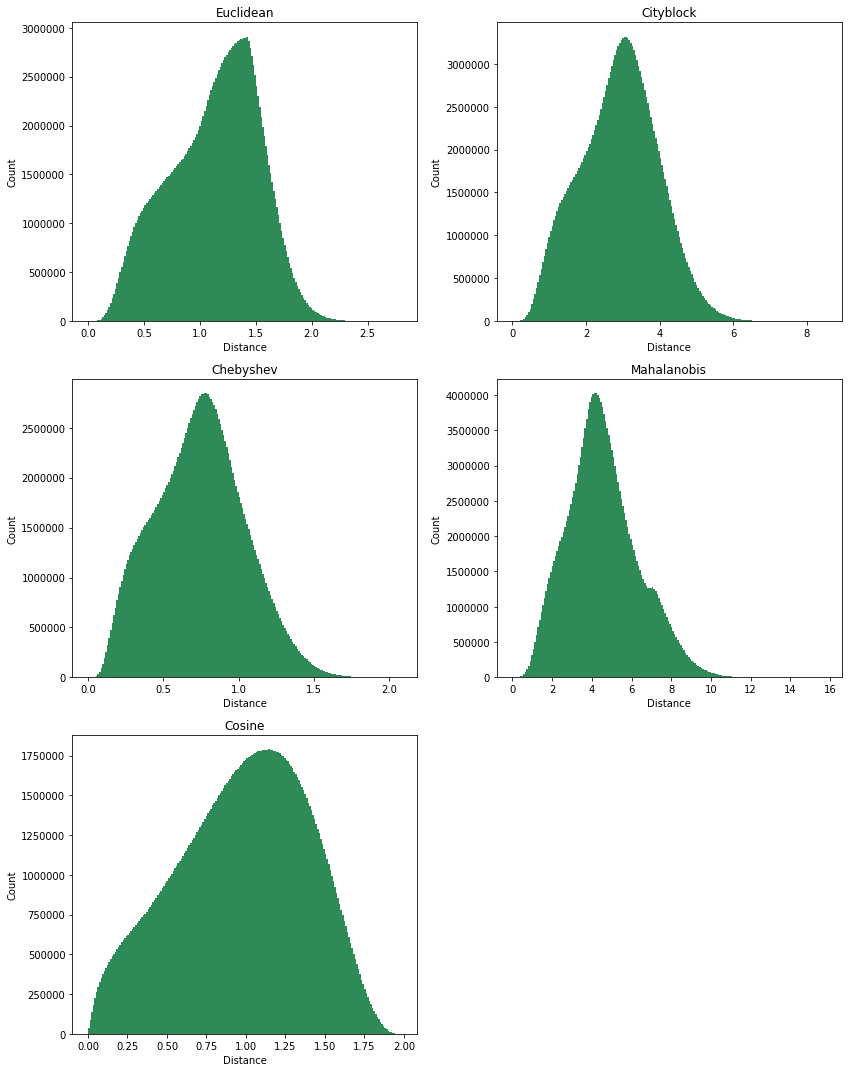

In [31]:
metrics = ['euclidean', 'cityblock', 'chebyshev', 'mahalanobis', 'cosine']

n_cols = 2
n_rows = len(metrics)//n_cols + int(len(metrics)%n_cols > 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))

for i,m in enumerate(metrics):
    pairDistList = pdist(X_pca, metric=m)
    ax = axs.flatten()[i]
    ax.hist(pairDistList, bins=200, color='seagreen')
    ax.set_title(m.title())
    ax.set_ylabel('Count')
    ax.set_xlabel('Distance')

for ax in axs.flatten()[(len(metrics)-n_cols*n_rows):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Unfortunately none of the alternative distance metrics above show any real improvement over our default euclidean approach in terms of identifying a possible epsilon. We will proceed with choosing the inflection point in place of a local minima past the first 'peak', giving us an approximate epsilon of 0.7. Using this value in tandem with a distribution of number of neighbours at or below said distance of epsilon yields the following:

In [32]:
def neighborhoods(data, epsilon):
    n_data = data.shape[0]
    nn = np.zeros(n_data)
    # Compute all - n(n-1)/2 - pairwise distances
    pMat = pdist(data)
    # Compute the (i,j) indexes of pairs that correspond to each elements in pMat
    indexes = np.array([ (i,j) for i in range(n_data) for j in range(i+1, n_data)])
    # Find pairs of data points that are closer than epsilon
    pairs = indexes[np.where(pMat < epsilon)]
    for pair in pairs:
        nn[pair[0]] += 1
        nn[pair[1]] += 1
    return nn

In [33]:
nn = neighborhoods(X_pca, 0.7)

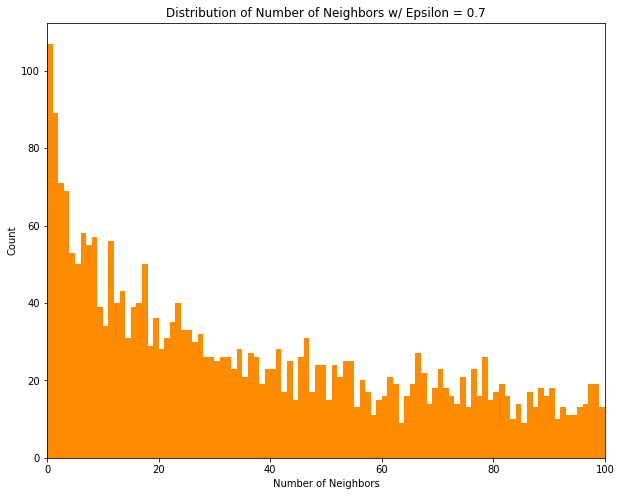

In [41]:
fig = plt.figure(figsize=(10,8))

ax=fig.gca()
ax.hist(nn, bins=np.arange(min(nn), max(nn) + 1, 1), color='darkorange')

ax.set_title('Distribution of Number of Neighbors w/ Epsilon = 0.7')
ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('Count')
ax.set_xlim(0,100)

plt.show()

Unfortunately, we do again do not have any maxima/minima to work with in identifying a possible value for the number of neighbors / min points to look for in DBSCAN. We can try to infer a value from the approximate elbow in the graph above as an alternative, which yield a value in the range of 20. We will fit DBSCAN with these parameters just to see how it performs:

In [43]:
db = DBSCAN(eps=0.7, min_samples=20)

start = time.time()
db.fit(X_pca)
print('Fit time: {:.2f}s'.format(time.time()-start))

Fit time: 19.49s


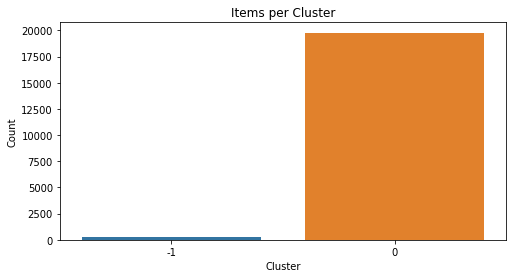

In [47]:
plt.figure(figsize=(8,4))

ax = sns.countplot(db.labels_)
ax.set_title('Items per Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Count')

plt.show()

The bar chart above shows that the majority of data was simply grouped into a single cluster, and a few data points were identified as noise (cluster # = -1). For the purposes of segmenting customers this obviously provides little use to us, so we will need to explore alternative parameters in the hopes of achieving better results.

An alternative method to identifying epsilon and min points/samples is via the i-th nearest neighbor plot, in which we look for when the distance to the i-th nearest neighbor begins to stabalize (i.e. elbow method). Typically it is suggested to evaluate this for i = 4 (equivalent to min samples = 4), but given our experience above with 20 points only producing a single cluster we will plot higher i values as well:

In [48]:
def kDist(data, k):
    # Number of data points
    nData = data.shape[0]
    # Pairwise distance matrix
    pDistMat = squareform(pdist(data))
    # Distance to i-th nearest neighbor for each data point
    kDistArray = [ sorted(pDistMat[i,:])[k-1] for i in range(nData)]
    return sorted(kDistArray, reverse=True)

In [31]:
# More efficient when running multiple i-th nearest neighbor evaluations
def kDist_multi(data, k_range):
    # Number of data points
    nData = data.shape[0]
    # Pairwise distance matrix
    pDistMat = squareform(pdist(data))
    # Sort list of distances for each data point
    kDistResults = {}
    kDistSorted = [ sorted(pDistMat[i,:]) for i in range(nData) ]
    for k in k_range:
        # Distance to i-th nearest neighbor for each data point
        kDistArray = [ kDistSorted[i][k-1] for i in range(nData)]
        kDistResults[k] = sorted(kDistArray, reverse=True)
    return kDistResults

In [51]:
kDistResults = kDist_multi(X_pca, [4,5,6,10,20])

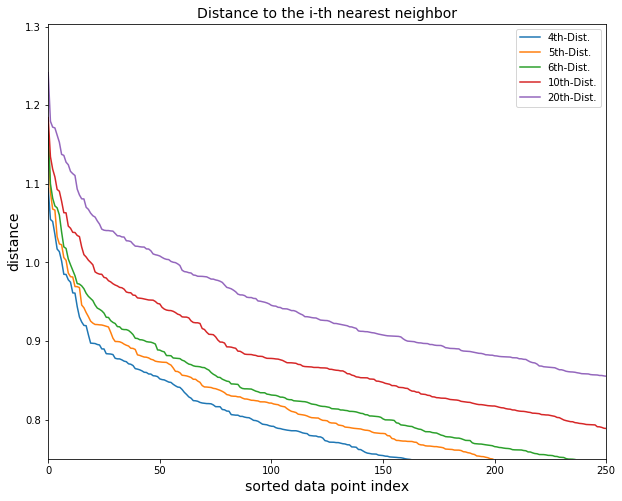

In [52]:
n_data = 20000

figKDist = plt.figure(figsize=(10,8))

for k in [4,5,6,10,20]:
    plt.plot(range(n_data), kDistResults[k], label='{}th-Dist.'.format(k))

plt.xlim([0,250])
plt.xlabel('sorted data point index', size=14)
plt.ylabel('distance', size=14)
plt.title('Distance to the i-th nearest neighbor', size=14)
plt.legend()
plt.ylim(bottom=0.75)

plt.show()

From the plots above we see distances at the elbows ranging from 0.9 to 1.1 depending on the i-th nearest neighbor evaluated. We will explore this range via gridsearch in tandem with various values of min points in the hopes of obtaining an ideal combination for obtaining several significant clusters:

In [32]:
def cluster_uniformity(cluster_counts):
    d = len(cluster_counts)
    if d <= 1:
        return np.nan
    n = sum(cluster_counts)
    # Represent cluster counts as proportion of all data (ranging 0-1)
    p = [count / n for count in cluster_counts]
    # L2 norm of proportions to approximate uniformity
    l2 = np.sqrt(sum([x**2 for x in p]))
    # Represent "uniformity" on 0-1 scale
    u = 1 - (l2*np.sqrt(d)-1)/(np.sqrt(d)-1)
    return u

def dbscan_gs(data, eps=[0.5,1.0], min_samples=[4,5,6], verbose=0):
    # GS start time
    f_start_time = time.time()
    
    # Number of fits to perform
    n_tests = len(eps)*len(min_samples)
    
    if verbose > 0:
        print('--- DBSCAN grid search ---')
        print('Total samples = {}'.format(data.shape[0]))
        print('eps values: {}'.format([round(e, 2) for e in eps]))
        print('min_samples values: {}'.format([ms for ms in min_samples]))
        print('# of Fits = {}'.format(n_tests))
        print('--------------------------')
    
    # create a dataframe for holding our results
    dbscan_results = pd.DataFrame(columns=['eps', 'min_samples', 'n_clusters', 'cluster_uniformity','cluster_counts','noise_pts'])
    dbscan_results = dbscan_results[['eps', 'min_samples', 'n_clusters', 'cluster_uniformity','cluster_counts','noise_pts']]

    # create values for testing eps & min samples
    params = {'eps': eps,
              'min_samples': min_samples}
    
    # Loop through param combos and fit DBSCAN
    for i, (e, ms) in enumerate(itertools.product(params['eps'],params['min_samples'])):
        # Fit start time
        
        start_time = time.time()
        if verbose > 0:
            print('eps: {:.3f}, min_samples: {:.0f}... Fitting DBSCAN {}/{}'.format(e,ms,i+1,n_tests), end='\r')
        
        db = DBSCAN(eps=e, min_samples=ms).fit(data)
        labels = db.labels_
        # Number of clusters
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        # Counts per clusters
        cluster_counts = np.bincount(labels[labels != -1]).tolist()
        # Number of noise points
        noise_pts = np.sum(labels < 0)
        # Calculate uniformity score
        cluster_uni = cluster_uniformity(cluster_counts) if n_clusters > 1 else np.nan
        
        if verbose > 0:
            time_delta = time.time() - start_time
            m = time_delta//60
            s = time_delta%60
            time_display = ('{}min '.format(m) if m > 0 else '') + '{:.2f}s'.format(s)
            print('eps: {:.3f}, min_samples: {:.0f}, clusters: {}, uniformity: {:.2f}, noise: {:d}   ({})'.format(e, ms, n_clusters, cluster_uni,noise_pts, time_display)) 

        # Create record to be added to dataframe
        df_pt = pd.DataFrame({'eps':[e],
                             'min_samples':[ms],
                             'n_clusters':[n_clusters],
                             'cluster_uniformity': cluster_uni,
                             'cluster_counts': [cluster_counts],
                             'noise_pts': [noise_pts]})

        dbscan_results = pd.concat([dbscan_results, df_pt],axis=0)
    
    if verbose > 0:
        time_delta = time.time() - f_start_time
        m = time_delta//60
        s = time_delta%60
        time_display = ('{}min '.format(m) if m > 0 else '') + '{:.2f}s'.format(s)
        print('--------------------------')
        print('Total run time: {}'.format(time_display))
    
    dbscan_results.reset_index(drop=True, inplace=True)
    return dbscan_results

In [54]:
dbscan_results = dbscan_gs(data=X_pca, eps=np.arange(0.5,1.11,0.1), min_samples=[5,10,15,20,50], verbose=1)

--- DBSCAN grid search ---
Total samples = 20000
eps values: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
min_samples values: [5, 10, 15, 20, 50]
# of Fits = 35
--------------------------
eps: 0.500, min_samples: 5, clusters: 1, uniformity: nan, noise: 1195   (13.75s)
eps: 0.500, min_samples: 10, clusters: 1, uniformity: nan, noise: 1477   (13.67s)
eps: 0.500, min_samples: 15, clusters: 2, uniformity: 0.00, noise: 1704   (13.69s)
eps: 0.500, min_samples: 20, clusters: 1, uniformity: nan, noise: 1918   (13.76s)
eps: 0.500, min_samples: 50, clusters: 3, uniformity: 0.03, noise: 2512   (13.65s)
eps: 0.600, min_samples: 5, clusters: 2, uniformity: 0.00, noise: 423   (16.92s)
eps: 0.600, min_samples: 10, clusters: 1, uniformity: nan, noise: 537   (16.81s)
eps: 0.600, min_samples: 15, clusters: 1, uniformity: nan, noise: 616   (16.92s)
eps: 0.600, min_samples: 20, clusters: 1, uniformity: nan, noise: 686   (16.77s)
eps: 0.600, min_samples: 50, clusters: 1, uniformity: nan, noise: 1065   (16.91s)
eps:

In [56]:
dbscan_results

,cluster_counts,cluster_uniformity,eps,min_samples,n_clusters,noise_pts
0,[18805],nan,0.50,5,1,1195
1,[18523],nan,0.50,10,1,1477
2,"[18270, 26]",0.00,0.50,15,2,1704
3,[18082],nan,0.50,20,1,1918
4,"[17242, 196, 50]",0.03,0.50,50,3,2512
5,"[19572, 5]",0.00,0.60,5,2,423
6,[19463],nan,0.60,10,1,537
7,[19384],nan,0.60,15,1,616
8,[19314],nan,0.60,20,1,686
9,[18935],nan,0.60,50,1,1065


The results above unfortunately were unable to provide any succesful combination. Most results again produced just one cluster, and the select few that produced more had cluster sizes less than one hundred samples versus the main cluster with the remaining 19k. We will see if exploring a smaller epsilon is able to produce more granular clusters:

In [58]:
dbscan_results_2 = dbscan_gs(data=X_pca, eps=np.arange(0.1,0.51,0.1), min_samples=[3,4,5,10,15,20,50,100], verbose=1)

--- DBSCAN grid search ---
Total samples = 20000
eps values: [0.1, 0.2, 0.3, 0.4, 0.5]
min_samples values: [3, 4, 5, 10, 15, 20, 50, 100]
# of Fits = 40
--------------------------
eps: 0.100, min_samples: 3, clusters: 114, uniformity: 0.33, noise: 17298   (1.81s)
eps: 0.100, min_samples: 4, clusters: 58, uniformity: 0.29, noise: 17625   (1.83s)
eps: 0.100, min_samples: 5, clusters: 32, uniformity: 0.27, noise: 17887   (1.79s)
eps: 0.100, min_samples: 10, clusters: 7, uniformity: 0.30, noise: 18473   (1.80s)
eps: 0.100, min_samples: 15, clusters: 6, uniformity: 0.30, noise: 18687   (1.80s)
eps: 0.100, min_samples: 20, clusters: 4, uniformity: 0.33, noise: 18893   (1.80s)
eps: 0.100, min_samples: 50, clusters: 2, uniformity: 0.51, noise: 19348   (1.79s)
eps: 0.100, min_samples: 100, clusters: 1, uniformity: nan, noise: 19676   (1.81s)
eps: 0.200, min_samples: 3, clusters: 107, uniformity: 0.08, noise: 10550   (4.17s)
eps: 0.200, min_samples: 4, clusters: 45, uniformity: 0.05, noise: 1096

In [59]:
dbscan_results_2

,cluster_counts,cluster_uniformity,eps,min_samples,n_clusters,noise_pts
0,"[6, 1869, 4, 218, 3, 4, 57, 8, 3, 3, 40, 7, 4,...",0.33,0.10,3,114,17298
1,"[4, 1757, 212, 4, 55, 40, 7, 20, 26, 9, 4, 11,...",0.29,0.10,4,58,17625
2,"[1624, 196, 55, 39, 17, 26, 9, 7, 6, 6, 9, 5, ...",0.27,0.10,5,32,17887
3,"[1232, 156, 47, 39, 17, 26, 10]",0.30,0.10,10,7,18473
4,"[1069, 129, 37, 38, 17, 23]",0.30,0.10,15,6,18687
5,"[918, 114, 37, 38]",0.33,0.10,20,4,18893
6,"[544, 108]",0.51,0.10,50,2,19348
7,[324],nan,0.10,100,1,19676
8,"[8801, 78, 4, 62, 71, 18, 9, 4, 3, 5, 5, 7, 7,...",0.08,0.20,3,107,10550
9,"[8612, 75, 58, 8, 10, 4, 70, 5, 8, 6, 4, 13, 4...",0.05,0.20,4,45,10969


Whilst we see a few instances of several clusters produces on the magnitude of 100 items, we seem to be unable to escape the bulk clustering of data into a singular cluster with at best a few small clusters accompanying it. The only point where cluster uniformity approaches a somewhat acceptable level is at the smallest epsilon values, which comes at the cost of discarding the majority of data as noise. We could explore ranges of epsilon and min samples in smaller intervals, but the evidence thus far indicates that DBSCAN is likely not the best approach for clustering.

##### DBSCAN on KMeans Clusters

Although we have somewhat settled on DBSCAN being unsuited for our clustering needs, it may interesting to see how it performs when we feed it with a reduced/compacted dataset. We were already forced to work with a subsample of our data due to memory constraints, but perhaps we can evaluate all data if we preprocess and simplif our data into small clusters via KMeans, and subsequently feed these cluster centroids into DBSCAN.

This will obviously require that KMeans produce a significant number of clusters/centroids, which may prove performance intensive. We will give it a trial run to establish feasibility:

In [24]:
d = 'p_mean_norm'
X = PCA(n_components=n_pca[d]).fit_transform(dept_data[d])

In [67]:
n = 1000
km = MiniBatchKMeans(n_clusters=n, batch_size=1000, init_size=3*n)

start_time = time.time()
km.fit(X)
print('Fit time = {:.2f}s'.format(time.time()-start_time))

Fit time = 10.40s


More than acceptable fit times, although we will likely need clusters on the magnitude of 10-20k to give DBSCAN a considerable set of data to work with. We will explore a few sets of n_clusters to see if any perform particular well:

In [25]:
n_range = np.arange(1000,10001,1000)
km_clusters = {}
for i, n in enumerate(n_range):
    print('Processing n = {:.0f} ({}/{})   '.format(n,i+1,n_range.shape[0]), end='\r')
    km_clusters[n] = MiniBatchKMeans(n_clusters=n, batch_size=1000, init_size=3*n)
    km_clusters[n].fit(X)
print('Complete',' '*100)

Complete                                                                                                     


In [29]:
km_clusters[1000].cluster_centers_

array([[ 0.11473657,  0.55010882,  0.03528859, ...,  0.19813931,
        -0.00265297,  0.01090531],
       [-0.06859103,  0.18722863,  0.44653214, ...,  0.00790173,
         0.01704463, -0.01047986],
       [ 0.86060213, -0.42694543,  0.1108825 , ..., -0.04115692,
        -0.04846939, -0.02888567],
       ...,
       [ 0.2794947 ,  0.46086616, -0.28883498, ..., -0.1591898 ,
        -0.04854712, -0.00539479],
       [ 0.20223165,  0.55334528, -0.04119928, ...,  0.08864422,
        -0.01278888, -0.01446374],
       [-0.11557262, -0.03754498,  0.5531129 , ...,  0.0909677 ,
        -0.01263067,  0.06178843]])

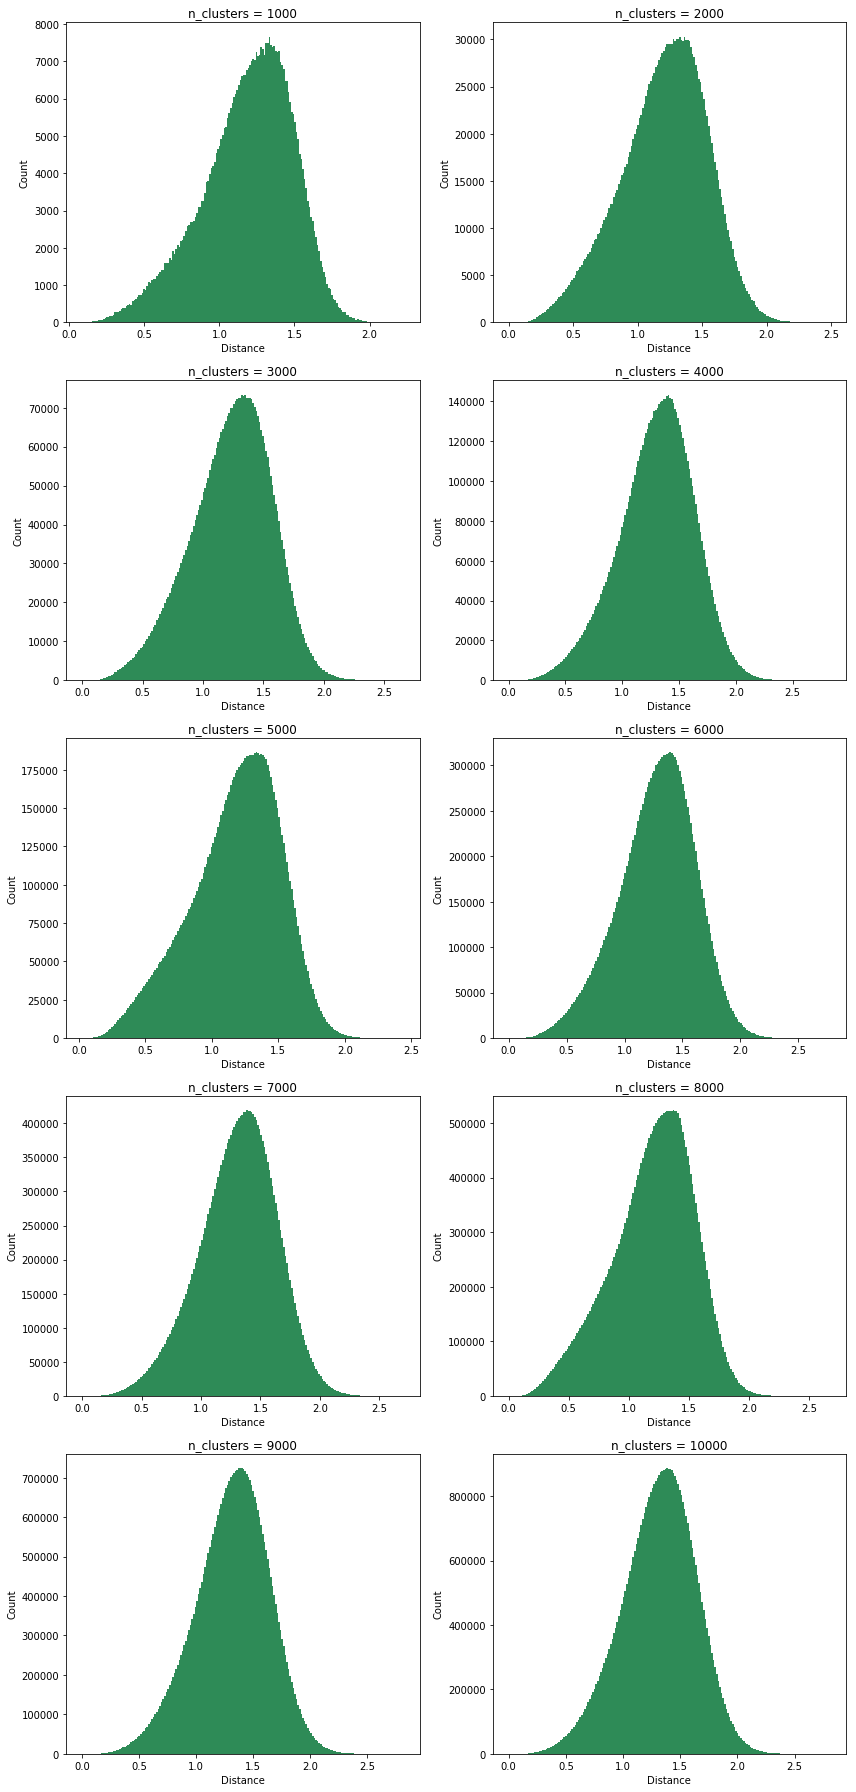

In [30]:
n_cols = 2
n_rows = len(km_clusters)//n_cols + int(len(km_clusters)%n_cols > 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))

for i, (n,km) in enumerate(km_clusters.items()):
    centroids = km.cluster_centers_
    pairDistList = pdist(centroids, metric='euclidean')
    ax = axs.flatten()[i]
    ax.hist(pairDistList, bins=200, color='seagreen')
    ax.set_title('n_clusters = {}'.format(n))
    ax.set_ylabel('Count')
    ax.set_xlabel('Distance')

extra = n_cols*n_rows - len(km_clusters)
if extra > 0:
    for ax in axs.flatten()[-extra:]:
        ax.axis('off')

plt.tight_layout()
plt.show()

Unfortunately, we seem to be encountering similar distributions of distances as before which do not provide us much in the ways of estimating an effective epsilon. Proceeding with the alternative i-th neighbor method:

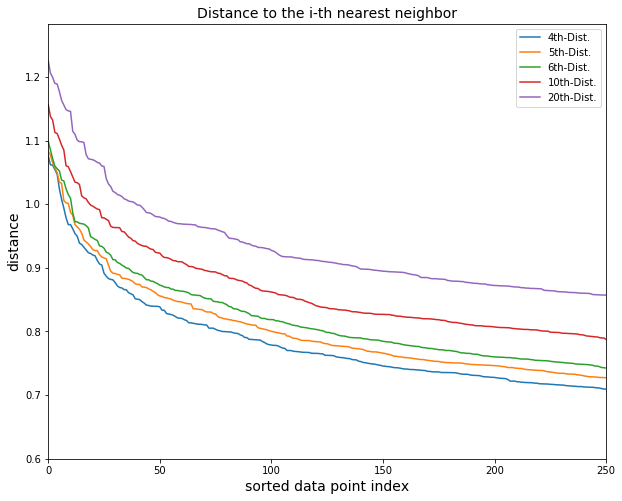

In [33]:
plt.figure(figsize=(10,8))

n = 10000
centroids = km_clusters[n].cluster_centers_
kDistResults = kDist_multi(centroids, [4,5,6,10,20])

for k in [4,5,6,10,20]:
    plt.plot(range(n), kDistResults[k], label='{}th-Dist.'.format(k))

plt.xlim([0,250])
plt.xlabel('sorted data point index', size=14)
plt.ylabel('distance', size=14)
plt.title('Distance to the i-th nearest neighbor', size=14)
plt.legend()
plt.ylim(bottom=0.6)

plt.show()

We can observe elbows in the plots above in the 0.8-1.0, so we will explore these in tandem with a range of min sample values via our grid search method:

In [34]:
n=10000
centroids = km_clusters[n].cluster_centers_
dbscan_results = dbscan_gs(centroids, eps=np.arange(0.5,1.0,0.1), min_samples=[4,5,6,10,12,15,20], verbose=1)

--- DBSCAN grid search ---
Total samples = 10000
eps values: [0.5, 0.6, 0.7, 0.8, 0.9]
min_samples values: [4, 5, 6, 10, 12, 15, 20]
# of Fits = 35
--------------------------
eps: 0.500, min_samples: 4, clusters: 4, uniformity: 0.00, noise: 1689   (3.30s)
eps: 0.500, min_samples: 5, clusters: 5, uniformity: 0.00, noise: 1805   (3.18s)
eps: 0.500, min_samples: 6, clusters: 3, uniformity: 0.00, noise: 1903   (3.42s)
eps: 0.500, min_samples: 10, clusters: 2, uniformity: 0.01, noise: 2256   (3.52s)
eps: 0.500, min_samples: 12, clusters: 3, uniformity: 0.01, noise: 2412   (3.50s)
eps: 0.500, min_samples: 15, clusters: 3, uniformity: 0.01, noise: 2602   (3.40s)
eps: 0.500, min_samples: 20, clusters: 2, uniformity: 0.03, noise: 2949   (3.49s)
eps: 0.600, min_samples: 4, clusters: 1, uniformity: nan, noise: 513   (4.43s)
eps: 0.600, min_samples: 5, clusters: 1, uniformity: nan, noise: 547   (4.71s)
eps: 0.600, min_samples: 6, clusters: 1, uniformity: nan, noise: 571   (4.56s)
eps: 0.600, min_s

In [35]:
dbscan_results

,cluster_counts,cluster_uniformity,eps,min_samples,n_clusters,noise_pts
0,"[8300, 3, 4, 4]",0.00,0.50,4,4,1689
1,"[8179, 4, 5, 4, 3]",0.00,0.50,5,5,1805
2,"[8089, 3, 5]",0.00,0.50,6,3,1903
3,"[7722, 22]",0.01,0.50,10,2,2256
4,"[7567, 15, 6]",0.01,0.50,12,3,2412
5,"[7367, 15, 16]",0.01,0.50,15,3,2602
6,"[6980, 71]",0.03,0.50,20,2,2949
7,[9487],nan,0.60,4,1,513
8,[9453],nan,0.60,5,1,547
9,[9429],nan,0.60,6,1,571


Unfotunately this has yielded nothing useful in terms of producing more than one meaningful cluster. Perhaps a smaller epsilon will show improvement:

In [36]:
n=10000
centroids = km_clusters[n].cluster_centers_
dbscan_results = dbscan_gs(centroids, eps=np.arange(0.1,0.5,0.05), min_samples=[3,4,5,10,12,15,20], verbose=1)

--- DBSCAN grid search ---
Total samples = 10000
eps values: [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
min_samples values: [3, 4, 5, 10, 12, 15, 20]
# of Fits = 56
--------------------------
eps: 0.100, min_samples: 3, clusters: 6, uniformity: 0.51, noise: 9944   (0.40s)
eps: 0.100, min_samples: 4, clusters: 3, uniformity: 0.42, noise: 9963   (0.38s)
eps: 0.100, min_samples: 5, clusters: 2, uniformity: 1.00, noise: 9973   (0.39s)
eps: 0.100, min_samples: 10, clusters: 1, uniformity: nan, noise: 9990   (0.40s)
eps: 0.100, min_samples: 12, clusters: 0, uniformity: nan, noise: 10000   (0.40s)
eps: 0.100, min_samples: 15, clusters: 0, uniformity: nan, noise: 10000   (0.40s)
eps: 0.100, min_samples: 20, clusters: 0, uniformity: nan, noise: 10000   (0.38s)
eps: 0.150, min_samples: 3, clusters: 14, uniformity: 0.23, noise: 9617   (0.58s)
eps: 0.150, min_samples: 4, clusters: 8, uniformity: 0.20, noise: 9665   (0.58s)
eps: 0.150, min_samples: 5, clusters: 5, uniformity: 0.16, noise: 9706   

In [37]:
dbscan_results

,cluster_counts,cluster_uniformity,eps,min_samples,n_clusters,noise_pts
0,"[38, 3, 6, 3, 3, 3]",0.51,0.10,3,6,9944
1,"[30, 4, 3]",0.42,0.10,4,3,9963
2,"[13, 14]",1.00,0.10,5,2,9973
3,[10],nan,0.10,10,1,9990
4,[],nan,0.10,12,0,10000
5,[],nan,0.10,15,0,10000
6,[],nan,0.10,20,0,10000
7,"[318, 16, 3, 4, 3, 10, 3, 5, 4, 3, 4, 3, 4, 3]",0.23,0.15,3,14,9617
8,"[292, 16, 8, 5, 4, 3, 3, 4]",0.20,0.15,4,8,9665
9,"[267, 15, 6, 3, 3]",0.16,0.15,5,5,9706


We seem to be unable to produce multiple clusters without discarding a lot of data points as noice, and as before the additional clusters produced contain a minimal number of samples. DBSCAN again appears to be ill suited for this data set even with this alternative setup.